# Checkpoint 3 - Multi-Class Classification of Walmart Product Data

## Overview

Our group is exploring the feasibility to predict price ranges from written Walmart product descriptions. In this report, we discuss the performance of several classifier models and review the results of our tuning process for our core algorithim.

We explore the following models:

1. $k$-Nearest Neighbors (Core Algorithm)
1. Logistic Regression
1. Random Forest
1. RBF (Radial Basis-Function) SVC

In [1]:
# Update the working directory to be the project root directory.
from pathlib import Path, PurePosixPath
PROJECT_DIR = Path.cwd().resolve().parents[0]
%cd {PROJECT_DIR}

D:\Repositories\rit\ISTE780\Project


In [2]:
# Display list of available pipeline tasks.
!doit list

clean_data        Clean the raw dataset (.csv) and place in the interim folder.
create_data_dir   Create the data directory.
create_env        Create new conda environment using 'environment.yaml'.
download_data     Download the dataset from Kaggle.
unpack_data       Unpack the raw dataset (.zip) as the (.csv) file.
update_env        Update existing conda environment using 'environment.yaml'.


## Data Review

The data used to fit our classifiers has received some preprocessing. Notably, we have removed features that were specific to Walmart operations (i.e., Walmart Lot and Item Numbers) and some erroneous features that were missing all or large amounts of data (i.e., the "Available" feature in the original dataset). We have also filtered out rows that were inappropriately listed as `$0.00 USD`.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display
data_uri = "data/interim/ecommerce_data-cleaned-0.2.2.csv"
products_raw = pd.read_csv(data_uri, index_col=0)
products_raw.head()

,brand,name,description,category_raw,price_raw,discount_raw,price_range
0,La Costeï¿½ï¿½a,"La Costena Chipotle Peppers, 7 OZ (Pack of 12)",We aim to show you accurate product informati...,"Food | Meal Solutions, Grains & Pasta | Canned...",31.93,31.93,"(30, 35]"
1,Equate,Equate Triamcinolone Acetonide Nasal Allergy S...,We aim to show you accurate product informati...,Health | Equate | Equate Allergy | Equate Sinu...,10.48,10.48,"(10, 20]"
2,AduroSmart ERIA,AduroSmart ERIA Soft White Smart A19 Light Bul...,We aim to show you accurate product informati...,Electronics | Smart Home | Smart Energy and Li...,10.99,10.99,"(10, 20]"
3,lowrider,"24"" Classic Adjustable Balloon Fender Set Chro...",We aim to show you accurate product informati...,Sports & Outdoors | Bikes | Bike Accessories |...,38.59,38.59,"(35, 40]"
4,Anself,Elephant Shape Silicone Drinkware Portable Sil...,We aim to show you accurate product informati...,Baby | Feeding | Sippy Cups: Alternatives to P...,5.81,5.81,"(0, 10]"


We would like to perform some preliminary preprocessing on the text fields, to ensure they place nicely with our classifiers.

In [4]:
# Download stopwords.
import nltk
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\effen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# Get the stopwords.
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import regex

# Setup function for cleaning text fields of stop words.
words = stopwords.words("english")
stemmer = PorterStemmer()
def clean_text(feature):
    return " ".join([stemmer.stem(i) for i in regex.sub("[^a-zA-Z0-9]", " ", feature).split() if i not in words]).lower()

In [6]:
# Clean the brand, name, and description fields.
products = products_raw.copy() #.iloc[:,].copy()
products['name'] = products.name.fillna("").apply(clean_text)
products['brand'] = products.brand.fillna("").apply(clean_text)
products['description'] = products.description.fillna("").apply(clean_text)
products['category_raw'] = products.category_raw.fillna("")
display(products)

,brand,name,description,category_raw,price_raw,discount_raw,price_range
0,la cost,la costena chipotl pepper 7 oz pack 12,we aim show accur product inform manufactur su...,"Food | Meal Solutions, Grains & Pasta | Canned...",31.93,31.93,"(30, 35]"
1,equat,equat triamcinolon acetonid nasal allergi spra...,we aim show accur product inform manufactur su...,Health | Equate | Equate Allergy | Equate Sinu...,10.48,10.48,"(10, 20]"
2,adurosmart eria,adurosmart eria soft white smart a19 light bul...,we aim show accur product inform manufactur su...,Electronics | Smart Home | Smart Energy and Li...,10.99,10.99,"(10, 20]"
3,lowrid,24 classic adjust balloon fender set chrome bi...,we aim show accur product inform manufactur su...,Sports & Outdoors | Bikes | Bike Accessories |...,38.59,38.59,"(35, 40]"
4,anself,eleph shape silicon drinkwar portabl silicon c...,we aim show accur product inform manufactur su...,Baby | Feeding | Sippy Cups: Alternatives to P...,5.81,5.81,"(0, 10]"
...,...,...,...,...,...,...,...
29994,ninechef,sheng xiang zhen shengxiangzhen snack onenin c...,we aim show accur product inform manufactur su...,"Food | Snacks, Cookies & Chips | Chips & Crisp...",45.99,45.99,"(45, 50]"
29996,shock sox,shock sox fork seal guard 29 36mm fork tube 4 ...,we aim show accur product inform manufactur su...,Sports & Outdoors | Bikes | Bike Components | ...,33.25,33.25,"(30, 35]"
29997,princ,princ gooseberri 300g,we aim show accur product inform manufactur su...,"Food | Meal Solutions, Grains & Pasta | Canned...",8.88,8.88,"(0, 10]"
29998,creat ion,creat ion grace 3 4 inch straight hair iron ci...,we aim show accur product inform manufactur su...,Beauty | Hair Care | Hair Styling Tools | Flat...,50.00,24.50,"(45, 50]"


## Investigating Term Frequency of the `name` Predictor

We performed some additional EDA into the predictors of the dataset since the last checkpoint. We've included the term frequency and wordcloud for the `name` predictor here.

In [7]:
terms = products.name
print(terms)

print('\n\nTerm Frequency for all words in \'name\':')

term_frequency = terms.str.split(expand=True).stack().value_counts()
print(term_frequency)

0                   la costena chipotl pepper 7 oz pack 12
1        equat triamcinolon acetonid nasal allergi spra...
2        adurosmart eria soft white smart a19 light bul...
3        24 classic adjust balloon fender set chrome bi...
4        eleph shape silicon drinkwar portabl silicon c...
                               ...                        
29994    sheng xiang zhen shengxiangzhen snack onenin c...
29996    shock sox fork seal guard 29 36mm fork tube 4 ...
29997                                princ gooseberri 300g
29998    creat ion grace 3 4 inch straight hair iron ci...
29999    green bell takuminowaza two way ear pick brass...
Name: name, Length: 29604, dtype: object


Term Frequency for all words in 'name':
oz           4892
pack         4614
2            3540
1            2943
3            2522
             ... 
bamba           1
costenita       1
slaplit         1
pinalen         1
2159            1
Length: 25129, dtype: int64


In [8]:
top_N = 20

term_frequency_TopN = terms.str.split(expand=True).stack().value_counts()[:top_N]

print('\n\nTerm Frequency for top '+str(top_N)+' most frequent terms in \'cleaned_name\':')
print(term_frequency_TopN)

# print(type(term_frequency_TopN))



Term Frequency for top 20 most frequent terms in 'cleaned_name':
oz        4892
pack      4614
2         3540
1         2943
3         2522
4         2204
6         2028
5         2012
black     1789
babi      1680
12        1541
bike      1505
8         1365
white     1295
set       1289
bag       1171
x         1142
men       1131
golf      1032
bicycl    1016
dtype: int64


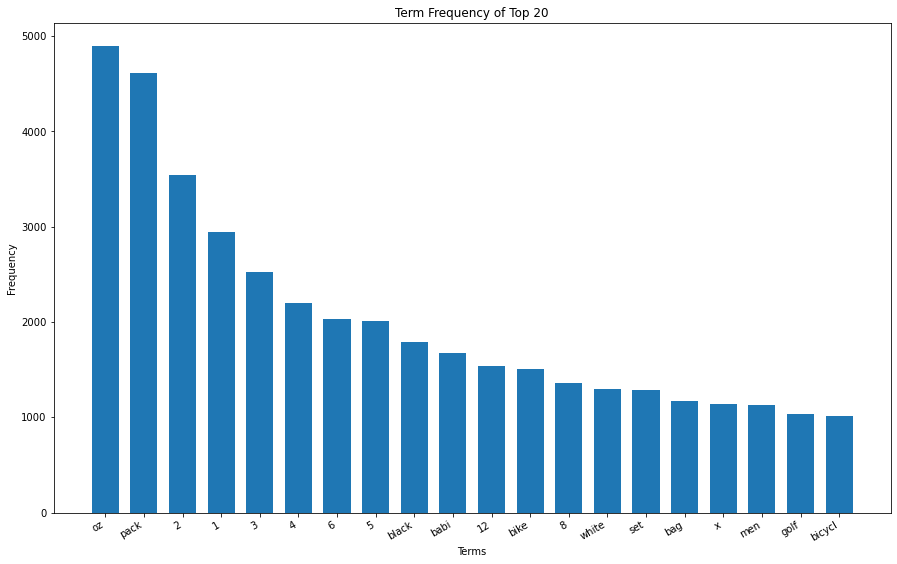

In [9]:
import matplotlib.pyplot as plt

X_axis_terms = term_frequency_TopN.keys()
Y_axis_frequency = term_frequency_TopN
indexes = np.arange(len(X_axis_terms))
# width = 0.7
plt.figure(figsize=(15,10))
plt.bar(indexes, Y_axis_frequency, 0.7)
# plt.xticks(indexes, X_axis_terms, rotation=120, fontweight='light', fontsize='x-small')
plt.xticks(indexes, X_axis_terms, rotation=45)
plt.title("Term Frequency of Top 20")
plt.xlabel("Terms")
plt.ylabel("Frequency")
plt.gcf().autofmt_xdate()
plt.show()

                term  frequency
oz                oz       4892
pack            pack       4614
2                  2       3540
1                  1       2943
3                  3       2522
...              ...        ...
bamba          bamba          1
costenita  costenita          1
slaplit      slaplit          1
pinalen      pinalen          1
2159            2159          1

[25129 rows x 2 columns]


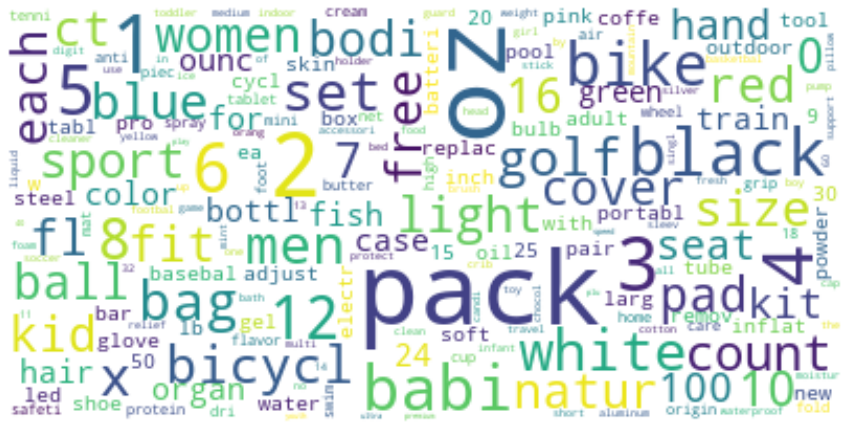

In [10]:
from wordcloud import WordCloud

frequency_terms = term_frequency.to_frame()
frequency_terms['term'] = frequency_terms.index
frequency_terms['frequency'] = frequency_terms[0]
frequency_terms = frequency_terms.iloc[: , 1:]
# frequency_terms.rename(columns={'0': 'frequency', 'term':'term'})
print(frequency_terms)

data = dict(zip(frequency_terms['term'].tolist(), frequency_terms['frequency'].tolist()))
wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate_from_frequencies(data)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Pipeline Setup

The following steps prepare the train test splits for the classifiers.

In [11]:
# Prepare the train/test splits.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Split data into features and labels:
X = products.loc[:,'brand':'category_raw']

# Encode labels.
le = LabelEncoder()
le.fit(products.loc[:,'price_range'].unique())
y = le.transform(products.loc[:,'price_range'])

# Split into the train test splits.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
display(f"X train: {X_train.shape}")
display(f"y train: {y_train.shape}")
display(f"X test: {X_test.shape}")
display(f"y test: {y_test.shape}")
display(X,y)
# display(le.inverse_transform(y_test))

'X train: (22203, 4)'

'y train: (22203,)'

'X test: (7401, 4)'

'y test: (7401,)'

,brand,name,description,category_raw
0,la cost,la costena chipotl pepper 7 oz pack 12,we aim show accur product inform manufactur su...,"Food | Meal Solutions, Grains & Pasta | Canned..."
1,equat,equat triamcinolon acetonid nasal allergi spra...,we aim show accur product inform manufactur su...,Health | Equate | Equate Allergy | Equate Sinu...
2,adurosmart eria,adurosmart eria soft white smart a19 light bul...,we aim show accur product inform manufactur su...,Electronics | Smart Home | Smart Energy and Li...
3,lowrid,24 classic adjust balloon fender set chrome bi...,we aim show accur product inform manufactur su...,Sports & Outdoors | Bikes | Bike Accessories |...
4,anself,eleph shape silicon drinkwar portabl silicon c...,we aim show accur product inform manufactur su...,Baby | Feeding | Sippy Cups: Alternatives to P...
...,...,...,...,...
29994,ninechef,sheng xiang zhen shengxiangzhen snack onenin c...,we aim show accur product inform manufactur su...,"Food | Snacks, Cookies & Chips | Chips & Crisp..."
29996,shock sox,shock sox fork seal guard 29 36mm fork tube 4 ...,we aim show accur product inform manufactur su...,Sports & Outdoors | Bikes | Bike Components | ...
29997,princ,princ gooseberri 300g,we aim show accur product inform manufactur su...,"Food | Meal Solutions, Grains & Pasta | Canned..."
29998,creat ion,creat ion grace 3 4 inch straight hair iron ci...,we aim show accur product inform manufactur su...,Beauty | Hair Care | Hair Styling Tools | Flat...


array([5, 1, 1, ..., 0, 8, 0])

In [12]:
# Prepare the pipeline.
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words="english", sublinear_tf=True, norm='l2')
column_transformer = ColumnTransformer([('name', vectorizer, 'name'),
                                        ('description', vectorizer, 'description'),
                                        ('brand', vectorizer, 'brand'),
                                        ('category_raw', vectorizer, 'category_raw'),
                                       ], remainder='drop', verbose_feature_names_out=False)

In [13]:
# Metric calculation function:
from sklearn.metrics import classification_report, confusion_matrix
def show_metrics(clf, test_X, test_y):
    print(f'Classification score: {clf.score(test_X, test_y) * 100}%')
    print(classification_report(np.array(test_y), clf.predict(test_X), zero_division=0))
    print(confusion_matrix(np.array(test_y), clf.predict(test_X)))

## Baseline Classifier

In order to compare our models to a reasonable baseline, we fit the model features using a `DummyClassifier` that makes predictions using simple rules.

In [14]:
# Import the DummyClassifier
from sklearn.dummy import DummyClassifier

# Create the DummyClassifier pipeline.
clf_dummy = Pipeline([('vect', column_transformer),
                      ('chi', SelectKBest(chi2, k=7000)),
                      ('clf', DummyClassifier(strategy='most_frequent'))])

# Fit the dummy classifier.
clf_dummy.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 ColumnTransformer(transformers=[('name',
                                                  TfidfVectorizer(stop_words='english',
                                                                  sublinear_tf=True),
                                                  'name'),
                                                 ('description',
                                                  TfidfVectorizer(stop_words='english',
                                                                  sublinear_tf=True),
                                                  'description'),
                                                 ('brand',
                                                  TfidfVectorizer(stop_words='english',
                                                                  sublinear_tf=True),
                                                  'brand'),
                                                 ('category_raw',
                    

In [15]:
show_metrics(clf_dummy, X_test, y_test)

Classification score: 26.347790839075802%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1619
           1       0.26      1.00      0.42      1950
           2       0.00      0.00      0.00       845
           3       0.00      0.00      0.00       576
           4       0.00      0.00      0.00       462
           5       0.00      0.00      0.00       318
           6       0.00      0.00      0.00       304
           7       0.00      0.00      0.00       232
           8       0.00      0.00      0.00       212
           9       0.00      0.00      0.00       883

    accuracy                           0.26      7401
   macro avg       0.03      0.10      0.04      7401
weighted avg       0.07      0.26      0.11      7401

[[   0 1619    0    0    0    0    0    0    0    0]
 [   0 1950    0    0    0    0    0    0    0    0]
 [   0  845    0    0    0    0    0    0    0    0]
 [   0  576    0    0    0    0    0    

The dummy classifier serves as a useful baseline: something to compare our models' performance against. In this instance, it selects the most frequent class in the label distribution and achieves a classification score of roughly $\approx 26.35$%.

## $k$-Nearest Neighbor Classifier

K-Nearest Neighbor (KNN) is a non-parametric classification algorithm that tries to classify a given observation to a response class with the highest estimated probability. For a given positive value of K, the classifier identifies K points from the training data set that are closest to the test observation (i.e. it’s K nearest neighbors). Then it computes the estimated conditional probability using the Bayes rule and classifies the test observation to the response class with the largest probability. In our project, KNN can be used to model the List Price of a Walmart product by finding the K-nearest neighbors and assigning the list price label that has the highest estimated probability.

In [16]:
from sklearn.neighbors import KNeighborsClassifier

# Create the baseline kNN pipeline
clf_kNN = Pipeline([('vect', column_transformer),
                      ('chi',  SelectKBest(chi2, k=7000)),
                      ('clf', KNeighborsClassifier())])

In [17]:
# Fit the kNN classifier.
clf_kNN.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 ColumnTransformer(transformers=[('name',
                                                  TfidfVectorizer(stop_words='english',
                                                                  sublinear_tf=True),
                                                  'name'),
                                                 ('description',
                                                  TfidfVectorizer(stop_words='english',
                                                                  sublinear_tf=True),
                                                  'description'),
                                                 ('brand',
                                                  TfidfVectorizer(stop_words='english',
                                                                  sublinear_tf=True),
                                                  'brand'),
                                                 ('category_raw',
                    

In [18]:
show_metrics(clf_kNN, X_test, y_test)

Classification score: 38.61640318875828%
              precision    recall  f1-score   support

           0       0.38      0.60      0.47      1619
           1       0.36      0.55      0.44      1950
           2       0.55      0.51      0.53       845
           3       0.25      0.08      0.12       576
           4       0.23      0.08      0.11       462
           5       0.32      0.07      0.11       318
           6       0.33      0.07      0.11       304
           7       0.77      0.10      0.18       232
           8       0.33      0.05      0.09       212
           9       0.39      0.25      0.31       883

    accuracy                           0.39      7401
   macro avg       0.39      0.24      0.25      7401
weighted avg       0.38      0.39      0.35      7401

[[ 967  564   37   15    9    1    2    0    2   22]
 [ 686 1077   50   41   20    8    5    0    2   61]
 [ 104  183  434    6    5    8    3    0    2  100]
 [ 184  258   24   45   32    3    3    0

### Tuning the $k$-Nearest Neighbor Classifier

We attempted to use the elbow method to calculate an optimal $k$ for our $k$-Nearest Neighbor classifier. We narrowed it down to a range between $[5, 12]$ on a smaller sample of ~2000 before applying our algorithm to the entire ~20,000+ records.

In [19]:
%%time
# Using the elbow method to find optimal K.
error_rate = []

tuple_range =range(5,12)
# Will take some time
for i in tuple_range:
    elb_KNN = Pipeline([('vect', column_transformer),
                      ('chi',  SelectKBest(chi2, k=7000)),
                      ('clf', KNeighborsClassifier(n_neighbors=i))])
    elb_KNN.fit(X_train, y_train)
    y_i = elb_KNN.predict(X_test)
    error_rate.append(np.mean(y_i != y_test))

Wall time: 1min 37s


Text(0, 0.5, 'Error Rate')

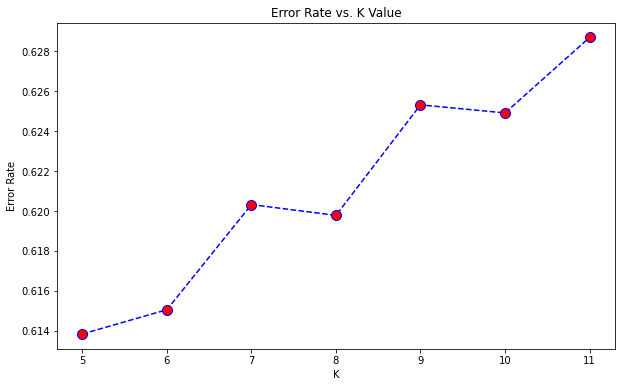

In [20]:
plt.figure(figsize=(10,6))
plt.plot(tuple_range,error_rate,color='blue', linestyle='dashed', marker='o',
 markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [21]:
from sklearn.model_selection import GridSearchCV

# Setup GridSearchCV for our model.
parameters = {'n_neighbors':range(5,10)}
knn = KNeighborsClassifier()
cv_KNN = GridSearchCV(knn, parameters)

# Create the baseline kNN pipeline
clf_kNN2 = Pipeline([('vect', column_transformer),
                      ('chi',  SelectKBest(chi2, k=7000)),
                      ('clf', cv_KNN)])

In [22]:
# Fit the kNN classifier.
clf_kNN2.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 ColumnTransformer(transformers=[('name',
                                                  TfidfVectorizer(stop_words='english',
                                                                  sublinear_tf=True),
                                                  'name'),
                                                 ('description',
                                                  TfidfVectorizer(stop_words='english',
                                                                  sublinear_tf=True),
                                                  'description'),
                                                 ('brand',
                                                  TfidfVectorizer(stop_words='english',
                                                                  sublinear_tf=True),
                                                  'brand'),
                                                 ('category_raw',
                    

Unfortunately, our grid search for hyperparameter tuning did not yield noticeable change.

In [23]:
show_metrics(clf_kNN2, X_test, y_test)

Classification score: 38.61640318875828%
              precision    recall  f1-score   support

           0       0.38      0.60      0.47      1619
           1       0.36      0.55      0.44      1950
           2       0.55      0.51      0.53       845
           3       0.25      0.08      0.12       576
           4       0.23      0.08      0.11       462
           5       0.32      0.07      0.11       318
           6       0.33      0.07      0.11       304
           7       0.77      0.10      0.18       232
           8       0.33      0.05      0.09       212
           9       0.39      0.25      0.31       883

    accuracy                           0.39      7401
   macro avg       0.39      0.24      0.25      7401
weighted avg       0.38      0.39      0.35      7401

[[ 967  564   37   15    9    1    2    0    2   22]
 [ 686 1077   50   41   20    8    5    0    2   61]
 [ 104  183  434    6    5    8    3    0    2  100]
 [ 184  258   24   45   32    3    3    0

## Logistic Regression

Logistic Regression is a statistical model that can be used to model the probability that the response Y belongs to a particular category/class. This is different from other classification algorithms that model the response Y directly. In our project, Logistic Regression can be used to model the probability that the List Price of a Walmart product belongs to any of the labels. Logistic Regression uses a logistic function to model a statistically dependent variable (typically binary). In a binary logistic regression problem, the dependent variable (i.e., the response Y) can have two possible categorical values such as “0” and “1".

In [24]:
from sklearn.linear_model import LogisticRegression

# Create the pipeline.
clf_logreg = Pipeline([('vect', column_transformer),
                      ('chi', SelectKBest(chi2, k=7000)),
                      ('clf', LogisticRegression(multi_class='multinomial', max_iter=1000))])

In [25]:
# Fit the classifier.
clf_logreg.fit(X_train, y_train)
show_metrics(clf_logreg, X_test, y_test)

Classification score: 42.66990947169301%
              precision    recall  f1-score   support

           0       0.49      0.56      0.52      1619
           1       0.38      0.63      0.48      1950
           2       0.57      0.63      0.60       845
           3       0.25      0.08      0.12       576
           4       0.23      0.07      0.11       462
           5       0.37      0.08      0.13       318
           6       0.44      0.07      0.12       304
           7       0.74      0.09      0.15       232
           8       0.44      0.05      0.09       212
           9       0.37      0.37      0.37       883

    accuracy                           0.43      7401
   macro avg       0.43      0.26      0.27      7401
weighted avg       0.42      0.43      0.39      7401

[[ 900  638   23   15   10    2    4    0    0   27]
 [ 519 1236   56   37   20    5    4    0    2   71]
 [  24  123  536    7    7    6    2    1    1  138]
 [ 112  313   26   47   17    3    0    1

Logistic regression performs much better than the dummy classifier, with a $42.67$% classification score. We could choose this model to further tune, changing the decision boundary probability to do so.

## Random Forest

The random forest classifier is an ensemble estimator that fits a series of decision trees on various sub-samples of the dataset. `sklearn`'s implementation uses bootstrapping by default and uses the `gini` index as a measure of node purity in each of the trees.

In [26]:
from sklearn.ensemble import RandomForestClassifier

# Create the pipeline.
clf_RF = Pipeline([('vect', column_transformer),
                   ('chi', SelectKBest(chi2, k=7000)),
                   ('clf', RandomForestClassifier())])

In [27]:
# Fit the classifier.
clf_RF.fit(X_train, y_train)
show_metrics(clf_RF, X_test, y_test)

Classification score: 43.84542629374409%
              precision    recall  f1-score   support

           0       0.50      0.61      0.55      1619
           1       0.37      0.64      0.47      1950
           2       0.58      0.64      0.61       845
           3       0.39      0.09      0.15       576
           4       0.38      0.10      0.16       462
           5       0.38      0.10      0.16       318
           6       0.48      0.08      0.14       304
           7       0.52      0.11      0.18       232
           8       0.43      0.09      0.15       212
           9       0.41      0.31      0.35       883

    accuracy                           0.44      7401
   macro avg       0.44      0.28      0.29      7401
weighted avg       0.44      0.44      0.40      7401

[[ 984  578   21    5    5    2    0    2    2   20]
 [ 542 1239   46   31   22   12    2    1    1   54]
 [  31  141  545    2    2    3    1    1    1  118]
 [ 116  320   26   52   19    9    2    1

## RBF (Radial Basis Function) SVC

SVC stands for C-Support Vector Classification. According to skcikit learn, "The fit time scales at least quadratically with the number of samples and may be impractical beyond tens of thousands of samples." SVC is using a radial basis function for its kernel to build a "one vs one" model. 

Support Vector Machines (SVMs) are used for solving supervised learning classification problems, but they can also be used for clustering and regression algorithms. SVM tries to find a hyperplane that separates the response classes with highest margin possible. The points that lie on the margins are called support vectors. SVM uses a kernel called radial basis function to build a one vs one model for the prediction with approximately 43% accuracy. RBF is the default kernel used within scikit-learn’s SVM algorithm, and it helps to control individual observation’s effect on the overall algorithm. Large values of gamma parameter indicate greater effect of test observation on the overall algorithm.

### Baseline SVC (RBF)

In [28]:
from sklearn.svm import SVC

# Create the pipeline.
clf_SVC = Pipeline([('vect', column_transformer),
                   ('chi',  SelectKBest(chi2, k=7000)),
                   ('clf', SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo'))])

In [29]:
# Fit the classifier.
clf_SVC.fit(X_train, y_train)

In [30]:
show_metrics(clf_SVC, X_test, y_test)

Classification score: 43.10228347520606%
              precision    recall  f1-score   support

           0       0.53      0.51      0.52      1619
           1       0.37      0.69      0.48      1950
           2       0.57      0.60      0.59       845
           3       0.35      0.08      0.13       576
           4       0.26      0.09      0.13       462
           5       0.47      0.09      0.16       318
           6       0.40      0.08      0.14       304
           7       0.71      0.09      0.15       232
           8       0.43      0.06      0.11       212
           9       0.39      0.38      0.38       883

    accuracy                           0.43      7401
   macro avg       0.45      0.27      0.28      7401
weighted avg       0.44      0.43      0.39      7401

[[ 829  714   29    8    8    1    5    1    1   23]
 [ 407 1338   59   30   26    6   10    0    0   74]
 [  21  152  511    1    4    2    2    0    2  150]
 [  82  349   20   47   27    5    1    0

We performed a cross-validation measurement of SVC on a small subset of ~2000 samples but it did not improve classification performance, so we elected not to run the full dataset on the cross-validation score.

## Summary

Fitting information from roughly 30,000 products is a computationally intensive process. One of the challenges we can address is fitting models on a smaller sub-sample of the data in such a way that our findings extrapolate well once we increase the amount of samples used. Initially, we setup our models using ~2000 samples from the larger population.

Considering that the `DummyClassifier` has a classification score of ~26%, there is a clear improvement to the process that comes from using the other models. Hyperparameter tuning can be used to improve the performance of the different models.

It is possible that we could redefine the classification we're trying to ask. Instead of the challenging multi-class classification, the problem domain could be reduced. Exploring a smaller number of labels or even turning the problem into a binary classification tasks may work well, especially in terms of something like the logistic regression model.